<style>
#s {
}
h1, h2, h3, h4, h5, h6, table, button, a, p, blockquote {
font-family:Geneva;
}

.log {
transition: all .2s ease-in-out;
}

.log:hover {a
transform: scale(1.05);
}
</style>
<div id='s' style='width:90%'>
<center><img class='log' src='https://splicemachine.com/wp-content/uploads/splice-logo-1.png' width='20%' style='z-index:5'></center>
<center><h1 class='log' style='font-size:40px; color:black;'>Welcome to Splice Machine MLManager</h1></center>
<center><h2 class = 'log' style='font-size:25px; color:grey;'>The data platform for intelligent applications</center>
<center><img class='log' src='https://splice-demo.s3.amazonaws.com/splice-machine-data-science-process-h2o.png' width='40%' style='z-index:5'></center>
</div>
    
    

# In this notebook, we're going to take a look at using MLManager with [H2O](https://www.h2o.ai/) + [Spark](https://spark.apache.org/)
<h2 style='font-size:25px;  font-weight:bold'>What is <a href=http://docs.h2o.ai/sparkling-water/2.1/latest-stable/doc/pysparkling.html>PySparkling Water?</a> What is <a href=https://splicemachine.com/product/ml-manager/>MLManager?</a></h2>
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>PySparkling</span></b> <br><br>PySparkling Water is an awesome H2O extension that allows you to run H2O clusters on top of existing Spark clusters. With Splice Machine, this integration is taken care of for you, so it's simple to start modeling with your new favorite library</i></br><footer>Splice Machine</footer></blockquote><br>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>MLManager (+MLFlow)</span></b><br><br>As a data scientist constantly creating new models and testing new features, it is necessary to effectively track and manage those different ML runs. MLManager + MLFlow allows you to track entire <code>experiments</code> and individual <code>run</code> parameters and metrics. The way you organize your flow is unique to you, and the intuitive Python API allows you to organize your development process and run with it.<br>
     <center><img class='log' src='https://s3.amazonaws.com/splice-demo/mlflow+ui.png' width='40%' style='z-index:5'></center>

# Let's get started
## In this notebook, we will see how to use Spark, H2O and MLManager to predict sentiment analysis of Amazon reviews, tracking everything in the [MLFlow UI](/mlflow) and deploy our models to production
This is an adaptation of the original [H2O Demo](http://docs.h2o.ai/h2o-tutorials/latest-stable/h2o-world-2017/nlp/index.html)

## Important imports and setup
* Create our Spark Session
* Create our Native Spark Data Source
* Create our PySparkling Water cluster
* Import our MLManager functionality

In [5]:
pip install --upgrade git+https://www.github.com/splicemachine/pysplice@DBAAS-3990

  Cloning https://www.github.com/splicemachine/pysplice (to revision DBAAS-3990) to /tmp/pip-req-build-tvecgxkt
  Running command git clone -q https://www.github.com/splicemachine/pysplice /tmp/pip-req-build-tvecgxkt
  Running command git checkout -b DBAAS-3990 --track origin/DBAAS-3990
  Switched to a new branch 'DBAAS-3990'
  Branch 'DBAAS-3990' set up to track remote branch 'DBAAS-3990' from 'origin'.
     |████████████████████████████████| 224 kB 17.6 MB/s eta 0:00:01
  Created wheel for splicemachine: filename=splicemachine-2.0.0-py3-none-any.whl size=54452 sha256=52b264eebf01c0a06154c7f5afe21982440aab1f7b0e37a04956721096c26a9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-e1e5ssi8/wheels/0c/58/ec/d4dd5d3e14310dcd82c132198196b6973a4139393dee4ddd79
Successfully built splicemachine
  Attempting uninstall: pytest
    Found existing installation: pytest 5.4.2
    Uninstalling pytest-5.4.2:
      Successfully uninstalled pytest-5.4.2
  Attempting uninstall: splicemachine
    Found 

In [45]:
from gensim.models import word2vec

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.


In [1]:
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
from splicemachine.mlflow_support import *
from pysparkling import *
import h2o

# Spark Session
spark = SparkSession.builder.config('spark.executor.memoryOverhead',1000).config('spark.executor.memory','5g').getOrCreate()
# Native Spark Data Source
splice = PySpliceContext(spark)
# Register Splice so we can access database functions
mlflow.register_splice_context(splice)
# Create H2O Cluster
conf = H2OConf().setInternalClusterMode()
hc = H2OContext.getOrCreate(conf)

Connecting to H2O server at http://10.128.29.75:54321 ... successful.


H2O cluster uptime:,12 secs
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,2 months and 15 days
H2O cluster name:,sparkling-water-jovyan_spark-application-1591024739826
H2O cluster total nodes:,2
H2O cluster free memory:,9.58 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,10
H2O cluster status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.28.1.2-1-2.4
 * H2O name: sparkling-water-jovyan_spark-application-1591024739826
 * cluster size: 2
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (2,10.128.29.196,54321)
  (1,10.128.24.122,54321)
  ------------------------

  Open H2O Flow in browser: http://10.128.29.75:54321 (CMD + click in Mac OSX)

    


# Great! Now let's import our data
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>Importing Data</span></b> <br><br>There are a few easy ways to get data into Splice Machine, and we'll demonstrate 2 of them here. You can use the built-in <code>%%sql</code> magic to import data directly from external sources, such as S3, or you can use H2O to directly read the data from S3, create a table from that dataframe, and insert the data directly using the <code>PySpliceContext</code> you created in the cell above. </i></br><footer>Splice Machine</footer></blockquote><br>

## Option 1: Direct Import from SQL
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>SQL Import</span></b> <br><br>This method is simple: Create your table, point it to a an S3 location, and run the import command</i></br><footer>Splice Machine</footer></blockquote><br>

In [5]:
%%sql
DROP TABLE IF EXISTS AMAZON_REVIEWS;
CREATE TABLE AMAZON_REVIEWS(
    PRODUCTID VARCHAR(250),
    USERID VARCHAR(250),
    SUMMARY VARCHAR(500),
    SCORE INT,
    HELPFULNESSDENOMINATOR BIGINT,
    ID INT,
    PROFILENAME VARCHAR(500),
    HELPFULNESSNUMERATOR BIGINT,
    REVIEW_TIME BIGINT,
    REVIEW VARCHAR(15000)
);


-- Import the data
call SYSCS_UTIL.IMPORT_DATA (
     null,
     'AMAZON_REVIEWS',
     null,
     's3a://splice-demo/AmazonReviews.csv',
     ',',
     null,
     null,
     null,
     null,
     -1,
     's3a://splice-demo/bad',
     null, 
     null);

In [6]:
%%sql
select top 10 * from AMAZON_REVIEWS

In [18]:
# Get data from table into Spark Dataframe
df2 = splice.df('select * from ben.amazon_reviews')
hdf = hc.asH2OFrame(df2)
hdf.describe()

Rows:99999
Cols:10




,PRODUCTID,USERID,SUMMARY,SCORE,HELPFULNESSDENOMINATOR,ID,PROFILENAME,HELPFULNESSNUMERATOR,REVIEW_TIME,REVIEW
type,string,string,string,int,int,int,string,int,int,string
mins,NaN,NaN,NaN,1.0,0.0,3.0,NaN,0.0,940809600.0,NaN
mean,NaN,NaN,NaN,4.186101861018614,2.236472364723653,284618.2923129232,NaN,1.745467454674545,1296171870.3267026,NaN
maxs,NaN,NaN,NaN,5.0,878.0,568436.0,NaN,866.0,1351209600.0,NaN
sigma,NaN,NaN,NaN,1.3095421878195728,8.805400733729007,164159.3591659328,NaN,8.17145025581287,48107386.40835985,NaN
zeros,0,0,0,0,47593,0,0,53553,0,0
missing,0,0,0,0,0,0,0,0,0,0
0,B002915VF2,A70T7QXN23ZXY,Fabulous healthy treat that tastes pretty darn good!,5.0,3.0,164348.0,Rachel Zaitz,2.0,1248825600.0,"I was a little skeptical about this product before I purchased it. However, I decided to try it out due to the positive reviews. I'm glad I did. For the unbelievably low calorie count for 1 pint of a frosty treat, this is a must buy! Is it just like ice cream? No. Is it a good substitute for something cold, relatively creamy and pleasant tasting? YES. I still don't know how they pack only 128 calories into this magical treat, but I guess I won't ask too many questions and instead just enjoy it while I have it. It is pricey and I would love to see the price drop a bit for repeat customers of this product perhaps, but overall I am very impressed."
1,B0038ZS6PU,A2UMUPYH9RTZKL,"Love,Love,Love This Flour",5.0,1.0,546392.0,PiperL,1.0,1325808000.0,I made no knead bread with this flour. It turned out fabulous. The recipe was a wet dough and I found the dough easy to handle and the taste developed over a 24 hr. fermentation period which is pretty fast. This flour is my new best friend.
2,B0039LVLS2,A1IX2EV3DOHTLG,Yummy snack,5.0,1.0,213810.0,Nancy Czajkowski,1.0,1337126400.0,"Very satisfying snack for very little calories. I originally tried the larger bag, until I found this size,perfect! Just grab and go and you know you have a single serving. Really fast delivery!! Give it a try."


## Option 2: Import from H2O
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>H2O Import</span></b> <br><br>This method is also straightforward, and may be preferable to Data Scientists: Import your data using H2O, and then use the <code>PySpliceContext</code> to create the table from the dataframe and insert the data directly</i></br><footer>Splice Machine</footer></blockquote><br>

In [7]:
data_path = "https://splice-demo.s3.amazonaws.com/AmazonReviews.csv"
# Load data into H2O
reviews = h2o.import_file(data_path)
reviews.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)<br /><br />They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats."
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!"
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.<br /><br />The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.<br /><br />If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amo

## H2O offers great functions to convert H2OFrames into Pandas and Spark DataFrames

In [8]:
# Spark DataFrame
df = hc.asSparkFrame(reviews)
df.limit(100).show()
print(type(df))
# Pandas DataFrame
pdf = reviews.head().as_data_frame()
display(pdf)
print(type(pdf))

+----------+--------------+--------------------+-----+----------------------+------+--------------------+--------------------+----------+--------------------+
| ProductId|        UserId|             Summary|Score|HelpfulnessDenominator|    Id|         ProfileName|HelpfulnessNumerator|      Time|                Text|
+----------+--------------+--------------------+-----+----------------------+------+--------------------+--------------------+----------+--------------------+
|B00141QYSQ|A1YS02UZZGRDCT|          Do Not Buy|    1|                     2| 41471|      Evan Eberhardt|                   2|1348358400|These are made in...|
|B0089SPEO2|A3JOYNYL458QHP|Less lemon and le...|    3|                     0| 28582|           coleridge|                   0|1323907200|Everything is ok,...|
|B001PMCDK2|A14TTMM0Z03Y2W|my cat goes crazy...|    5|                     0|389965| Lindsay S. Bradford|                   0|1310601600|Best cat treat ev...|
|B002Q8JOSI|A17UQD2RSSQH5X|My dogs tell me t..

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1323907200,"Everything is ok, except it just isn't as good..."
2,B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1310601600,Best cat treat ever. There isn't anything comp...
3,B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1316131200,My two Corgis were thoroughly spoiled by my la...
4,B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1334793600,We used to have drive down to the specialty pe...
5,B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1277251200,"I really liked this coffee, it was just as goo..."
6,B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1343692800,"I am always looking for healthier, whole grain..."
7,B001R3BQFW,AM50E42AFUVNL,Taste great.,5,0,126555,"T. Higley ""Tina""",0,1323561600,"I have tried many different drink mix, this is..."
8,B005HGAV8I,A2I5KDNOESGJ1H,variety galore,5,1,438837,TJ,1,1334016000,This is my favorite item to order for my Keuri...
9,B000GFYRHQ,A3A7YUR6FS6ZCI,Bigelow Earl Grey Green Tea,5,0,245379,Tea Lover,0,1178409600,"Tastes like Earl Grey, but it's green tea so i..."


<class 'pandas.core.frame.DataFrame'>


## Nice!
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>H2O Import</span></b> <br><br>Now that we have our Spark DataFrame, we can create a table and insert data using <code>splice.createTable</code> and <code>splice.insert</code><br><b>Note: </b>If your code is hanging on the <code>insert</code> your cluser may be out of memory. Try configuring your Spark or H2O cluster with more memory. Read about that <a href=https://docs.h2o.ai/sparkling-water/2.1/latest-stable/doc/configuration/configuration_properties.html>here</a> and <a href=https://spark.apache.org/docs/latest/configuration.html#available-properties>here</a></footer></blockquote><br>


In [4]:
help(splice.createTable)
print('----------------------------------------------------------------------------------------------------------------')
help(splice.insert)

Help on method createTable in module splicemachine.spark.context:

createTable(dataframe, schema_table_name, primary_keys=None, create_table_options=None, to_upper=False, drop_table=False) method of splicemachine.spark.context.PySpliceContext instance
    Creates a schema.table from a dataframe
    :param dataframe: The Spark DataFrame to base the table off
    :param schema_table_name: str The schema.table to create
    :param primary_keys: List[str] the primary keys. Default None
    :param create_table_options: str The additional table-level SQL options default None
    :param to_upper: bool If the dataframe columns should be converted to uppercase before table creation
                        If False, the table will be created with lower case columns. Default False
    :param drop_table: bool whether to drop the table if it exists. Default False. If False and the table exists,
                       the function will throw an exception.

-------------------------------------------

In [438]:
pip install --upgrade git+http://www.github.com/splicemachine/pysplice@DBAAS-3990

  Cloning http://www.github.com/splicemachine/pysplice (to revision DBAAS-3990) to /tmp/pip-req-build-g1rnih7t
  Running command git clone -q http://www.github.com/splicemachine/pysplice /tmp/pip-req-build-g1rnih7t
  Running command git checkout -b DBAAS-3990 --track origin/DBAAS-3990
  Switched to a new branch 'DBAAS-3990'
  Branch 'DBAAS-3990' set up to track remote branch 'DBAAS-3990' from 'origin'.
  Created wheel for splicemachine: filename=splicemachine-2.0.0-py3-none-any.whl size=54452 sha256=9078468eb246d79d8a4b90da2efe9676214f1d648f2874877456e0baf830cd3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-5pnf6puv/wheels/4e/a7/2b/f72322ec9cfd5fdd9467dfbcae791279bb5a69cab50e58af12
Successfully built splicemachine
  Attempting uninstall: splicemachine
    Found existing installation: splicemachine 2.0.0
    Uninstalling splicemachine-2.0.0:
      Successfully uninstalled splicemachine-2.0.0
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Create the table
schema = 'REPLACE_ME_DBSCHEMA'
df = df.withColumnRenamed('Time', 'Review_Time')
df = df.withColumnRenamed('Text', 'Review')
splice._dropTableIfExists(f'{schema}.AMAZON_REVIEWS_H2O')
splice.createTable(df, f'{schema}.AMAZON_REVIEWS_H2O', to_upper=True)
splice.insert(df, f'{schema}.AMAZON_REVIEWS_H2O',to_upper=True) # Use to_upper to give the SQL table uppercase letters

Droping table BEN.AMAZON_REVIEWS_H2O


KeyboardInterrupt: 

In [39]:
%%sql
select top 10 ProductId, UserId, Score  from AMAZON_REVIEWS_H2O;

KeyboardInterrupt: 

# Awesome! Let's get modeling
<style>
blockquote{
  font-size: 15px;
  background: #f9f9f9;
  border-left: 10px solid #ccc;
  margin: .5em 10px;
  padding: 30em, 10px;
  quotes: "\201C""\201D""\2018""\2019";
  padding: 10px 20px;
  line-height: 1.4;
}

blockquote:before {
  content: open-quote;
  display: inline;
  height: 0;
  line-height: 0;
  left: -10px;
  position: relative;
  top: 30px;
  bottom:30px;
  color: #ccc;
  font-size: 3em;
    display:none;

}

p{
  margin: 0;
}

footer{
  margin:0;
  text-align: right;
  font-size: 1em;
  font-style: italic;
}
</style>
<blockquote><p class='quotation'><b><br><span style='font-size:25px'>Modeling</span></b> <br><br>We're going to try three different ways to approach this problem, and track it all with MLManager. 
    <ol>
        <li>No Text Model: We will try to predict the customer reviews without using the text from the review. Just the Numeric Columns</li>
        <li>Using the reviews: We will use Word2Vec to create vectors from the text of the reviews. We will then train a model on that word embedding feature-vector</li>
        <li>Using the review summaries: We will use Word2Vec to create vectors from the text of the review summaries</li>
    </ol>
    Which do you think will perform the best?
    </i></br><footer>Splice Machine</footer></blockquote><br>

## First Attempt
Let's create a simple model using the non-review columns
<br>
<blockquote>
    First, let's start our mlflow experiment! We can start a run and log import parameters, tags, and metrics as they come<br>
Next, we can turn this into a binary-classification problem by turning score into a positive or negative review. We will say that 4 and 5 start reviews are positive, but you can change this and try other things!
</br><footer>Splice Machine</footer></blockquote><br>

In [9]:
# Set our mlflow experiment
mlflow.set_experiment('Sentiment Analysis')
# Look at our dataframe
reviews["PositiveReview"] = (reviews["Score"] >= 4).ifelse("1", "0")
reviews["PositiveReview"].table()


INFO: 'Sentiment Analysis' does not exist. Creating a new experiment


PositiveReview,Count
0,21791
1,78209


## Let's see our Data Correlation

PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


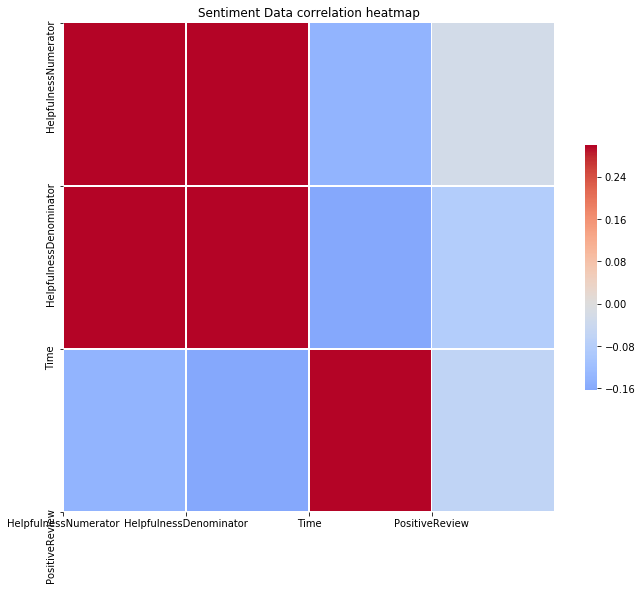

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql.types import FloatType, IntegerType

%matplotlib inline

pdf = reviews[['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time','PositiveReview']].as_data_frame()
corr = pdf.corr()

ticks = [i for i in range(len(corr.columns))]
# Generate a mask for the upper triangle

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Color Scheme
cmap = "coolwarm"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(ticks, corr.columns)
plt.yticks(ticks, corr.columns)
plt.title('Sentiment Data correlation heatmap')
plt.show()


## We can see some of our features have decent correlation (remember that we aren't using the reviews yet). Let's try a basic model
### First, let's log some important information in our <code>run</code>
<blockquote>H2O Has a <a href=https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science.html>lot</a> of algorithms, so we'll use a Gradient Boosting Estimator<br>We'll log some things like our feature vector, label, train/test/validation split, training time, and even the model and notebook themselves directly to <a href='/mlflow'>mlflow</a></blockquote>

In [44]:
%%time
from h2o.estimators import H2OGradientBoostingEstimator
from splicemachine.mlflow_support.utilities import get_user

RATIOS = [0.7,0.15]

# Start our run to keep track of important information
mlflow.start_run(run_name='simple_run')

predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

# lp is short for log_param
# lm is short for log_metric
mlflow.lp('predictors', predictors)
mlflow.lp('label', response)
mlflow.lp('source data table', f'{get_user()}.AMAZON_REVIEWS')

# Train Test Split
train,test,valid = reviews.split_frame(ratios=RATIOS)
# Log our ratios
mlflow.lp('ratios',RATIOS)

gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                            stopping_rounds = 5, score_tree_interval = 10,
                                            model_id = "gbm_baseline.hex"
                                           )

mlflow.lp('model_type', gbm_baseline.__class__)

# Code block to time training
with mlflow.timer('train_time'):
    gbm_baseline.train(x = predictors, y = response, 
                       training_frame = train, validation_frame = test
                      )
# Log the model params to mlflow
mlflow.log_params(gbm_baseline.get_params())
# Log the model to MLFlow
mlflow.log_model(gbm_baseline, 'baseline_model')
# Log the training notebook to MLFlow
mlflow.log_artifact('MLManager H2O Demo.ipynb', 'training_notebook')
gbm_baseline

Starting Code Block train_time... gbm Model Build progress: |███████████████████████████████████████████████| 100%
Done.
Code Block train_time:
Ran in 6.216 secs
Ran in 0.104 mins
Saving artifact of size: 1584.281 KB to Splice Machine DB
Saving artifact of size: 310.352 KB to Splice Machine DB
CPU times: user 750 ms, sys: 68.5 ms, total: 818 ms
Wall time: 12.1 s
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_baseline.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,25959.0,5.0,5.0,5.0,26.0,32.0,30.78




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13519480049697202
RMSE: 0.36768845575700637
LogLoss: 0.43326115755931044
Mean Per-Class Error: 0.3027351317098821
AUC: 0.7641567683211429
AUCPR: 0.9067923294138088
Gini: 0.5283135366422858

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5075220558469353: 


,,0,1,Error,Rate
0,0,3904.0,11261.0,0.7426,(11261.0/15165.0)
1,1,1186.0,53583.0,0.0217,(1186.0/54769.0)
2,Total,5090.0,64844.0,0.178,(12447.0/69934.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.507522,0.895939,267.0
1,max f2,0.267858,0.949974,339.0
2,max f0point5,0.751349,0.868164,164.0
3,max accuracy,0.577385,0.823448,241.0
4,max precision,0.949650,1.000000,0.0
5,max recall,0.076643,1.000000,393.0
6,max specificity,0.949650,1.000000,0.0
7,max absolute_mcc,0.749414,0.397431,165.0
8,max min_per_class_accuracy,0.818968,0.687966,114.0
9,max mean_per_class_accuracy,0.786125,0.697265,141.0



Gains/Lift Table: Avg response rate: 78.32 %, avg score: 78.31 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010009,0.927720,1.256825,1.256825,0.984286,0.935431,0.984286,0.935431,0.012580,0.012580,25.682479,25.682479
1,,2,0.020047,0.919124,1.245968,1.251389,0.975783,0.922727,0.980029,0.929070,0.012507,0.025087,24.596837,25.138884
2,,3,0.030071,0.914102,1.236817,1.246531,0.968616,0.916376,0.976224,0.924839,0.012398,0.037485,23.681662,24.653143
3,,4,0.040081,0.910879,1.231287,1.242724,0.964286,0.912374,0.973243,0.921726,0.012324,0.049809,23.128699,24.272440
4,,5,0.050133,0.908283,1.198787,1.233914,0.938834,0.909526,0.966343,0.919280,0.012051,0.061860,19.878740,23.391444
5,,6,0.100194,0.898486,1.195557,1.214750,0.936304,0.903580,0.951334,0.911435,0.059851,0.121711,19.555730,21.474956
6,,7,0.149999,0.891077,1.177540,1.202395,0.922194,0.895366,0.941659,0.906100,0.058646,0.180358,17.753987,20.239481
7,,8,0.200003,0.881357,1.173921,1.195276,0.919359,0.886103,0.936084,0.901100,0.058701,0.239059,17.392108,19.527587
8,,9,0.300026,0.862609,1.136149,1.175564,0.889778,0.874319,0.920646,0.892172,0.113641,0.352700,13.614935,17.556421
9,,10,0.400063,0.840679,1.125766,1.163112,0.881647,0.849132,0.910894,0.881410,0.112618,0.465318,12.576598,16.311198




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1434762548934531
RMSE: 0.37878259581645657
LogLoss: 0.45506218475133076
Mean Per-Class Error: 0.3298965890404755
AUC: 0.7334817035757148
AUCPR: 0.8865098863706123
Gini: 0.4669634071514297

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46405678657606786: 


,,0,1,Error,Rate
0,0,708.0,2671.0,0.7905,(2671.0/3379.0)
1,1,198.0,11467.0,0.017,(198.0/11665.0)
2,Total,906.0,14138.0,0.1907,(2869.0/15044.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.464057,0.888811,288.0
1,max f2,0.295058,0.947700,340.0
2,max f0point5,0.699999,0.856361,194.0
3,max accuracy,0.538577,0.812217,260.0
4,max precision,0.946930,1.000000,0.0
5,max recall,0.092448,1.000000,394.0
6,max specificity,0.946930,1.000000,0.0
7,max absolute_mcc,0.663169,0.372715,207.0
8,max min_per_class_accuracy,0.822941,0.659751,112.0
9,max mean_per_class_accuracy,0.805133,0.670103,130.0



Gains/Lift Table: Avg response rate: 77.54 %, avg score: 78.43 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010037,0.925631,1.255507,1.255507,0.973510,0.933215,0.973510,0.933215,0.012602,0.012602,25.550651,25.550651
1,,2,0.020008,0.918181,1.195094,1.225401,0.926667,0.921323,0.950166,0.927289,0.011916,0.024518,19.509416,22.540069
2,,3,0.030178,0.913738,1.222236,1.224334,0.947712,0.915802,0.949339,0.923418,0.012430,0.036948,22.223623,22.433425
3,,4,0.040016,0.910767,1.193816,1.216831,0.925676,0.912035,0.943522,0.920619,0.011745,0.048693,19.381611,21.683145
4,,5,0.050253,0.908108,1.155678,1.204374,0.896104,0.909277,0.933862,0.918309,0.011830,0.060523,15.567827,20.437432
5,,6,0.100040,0.898880,1.188080,1.196265,0.921228,0.903672,0.927575,0.911025,0.059151,0.119674,18.808046,19.626529
6,,7,0.150027,0.891282,1.188486,1.193673,0.921543,0.895565,0.925565,0.905874,0.059408,0.179083,18.848574,19.367325
7,,8,0.200678,0.881355,1.145809,1.181592,0.888451,0.885977,0.916197,0.900852,0.058037,0.237120,14.580913,18.159228
8,,9,0.300053,0.862832,1.120589,1.161389,0.868896,0.874643,0.900532,0.892172,0.111359,0.348478,12.058948,16.138865
9,,10,0.401555,0.841010,1.104707,1.147061,0.856582,0.849479,0.889422,0.881380,0.112130,0.460609,10.470746,14.706119




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-05-29 14:18:17,0.201 sec,0.0,0.412098,0.522889,0.500000,0.000000,1.000000,0.216847,0.417396,0.532854,0.500000,0.000000,1.000000,0.224608
1,,2020-05-29 14:18:19,2.205 sec,10.0,0.384889,0.467709,0.719285,0.884236,1.238747,0.187176,0.391486,0.479752,0.711396,0.875962,1.227600,0.194961
2,,2020-05-29 14:18:20,3.161 sec,20.0,0.376304,0.451300,0.732970,0.890938,1.226607,0.184946,0.383442,0.464608,0.722386,0.880443,1.225186,0.191704
3,,2020-05-29 14:18:20,3.696 sec,30.0,0.372844,0.444146,0.742384,0.895676,1.245880,0.182343,0.380811,0.459299,0.728109,0.883967,1.230665,0.188780
4,,2020-05-29 14:18:21,4.423 sec,40.0,0.369946,0.438014,0.754500,0.902222,1.257107,0.179412,0.379515,0.456591,0.731758,0.885341,1.255507,0.190840
5,,2020-05-29 14:18:22,4.845 sec,50.0,0.367688,0.433261,0.764157,0.906792,1.256825,0.177982,0.378783,0.455062,0.733482,0.886510,1.255507,0.190707



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,HelpfulnessNumerator,5264.813477,1.000000,0.421998
1,HelpfulnessDenominator,4238.071289,0.804980,0.339700
2,Time,1359.102417,0.258148,0.108938
3,ProductId,1185.762085,0.225224,0.095044
4,UserId,428.166962,0.081326,0.034319


## You can see above that H2O gives you loads of details about your model. Let's inspect it a bit more and log some results to MLFlow

In [142]:
%matplotlib inline  

# Print and Log Model params
params = dict(zip(gbm_baseline.summary().col_header[1:],
                    gbm_baseline.summary().cell_values[0][1:]))
print(gbm_baseline.summary())
mlflow.log_params(params)



Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,25959.0,5.0,5.0,5.0,26.0,32.0,30.78


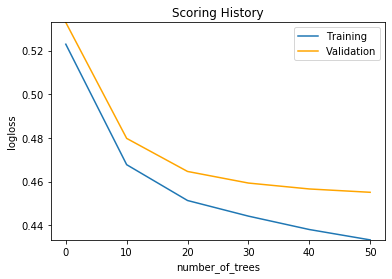

AUC on Validation Data: 0.733


In [58]:
from IPython.core.display import HTML
#Plot and Log Scoring history
gbm_baseline.plot()
print("AUC on Validation Data: " + str(round(gbm_baseline.auc(valid = True), 3)))
# Log training and validation metrics over time
for step, row in gbm_baseline.scoring_history().iterrows():
    row_dict = row.to_dict()
    for r in row_dict:
        if 'train' in r or 'valid' in r:
            mlflow.log_metric(r, row_dict[r],step=step)

cur_run = mlflow.current_run_id()
cur_exp = mlflow.current_exp_id()
link = f'/mlflow/#/metric/training_auc?runs=["{cur_run}"]&experiment={cur_exp}&plot_metric_keys=["training_logloss",\"validation_logloss\",\"training_rmse\",\"validation_rmse\"]'
HTML(f'See your metrics plot <a href={link}>here</a>')



In [111]:
# Print and Log Confusion Matrix
print(gbm_baseline.confusion_matrix(valid = True))
mlflow.lm('fpr', gbm_baseline.fpr(valid=True)[0][0])
mlflow.lm('tpr', gbm_baseline.tpr(valid=True)[0][0])
mlflow.lm('fnr', gbm_baseline.fnr(valid=True)[0][0])
mlflow.lm('tnr', gbm_baseline.fnr(valid=True)[0][0])
mlflow.lm('F0point5', gbm_baseline.F0point5(valid=True)[0][1])
mlflow.lm('F1', gbm_baseline.F1(valid=True)[0][1])
mlflow.lm('F2', gbm_baseline.F2(valid=True)[0][1])
mlflow.lm('auc', gbm_baseline.auc(valid = True))
mlflow.lp('threshold', gbm_baseline.F1(valid=True)[0][0]) # First element is the threshold


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46405678657606786: 


,,0,1,Error,Rate
0,0,708.0,2671.0,0.7905,(2671.0/3379.0)
1,1,198.0,11467.0,0.017,(198.0/11665.0)
2,Total,906.0,14138.0,0.1907,(2869.0/15044.0)


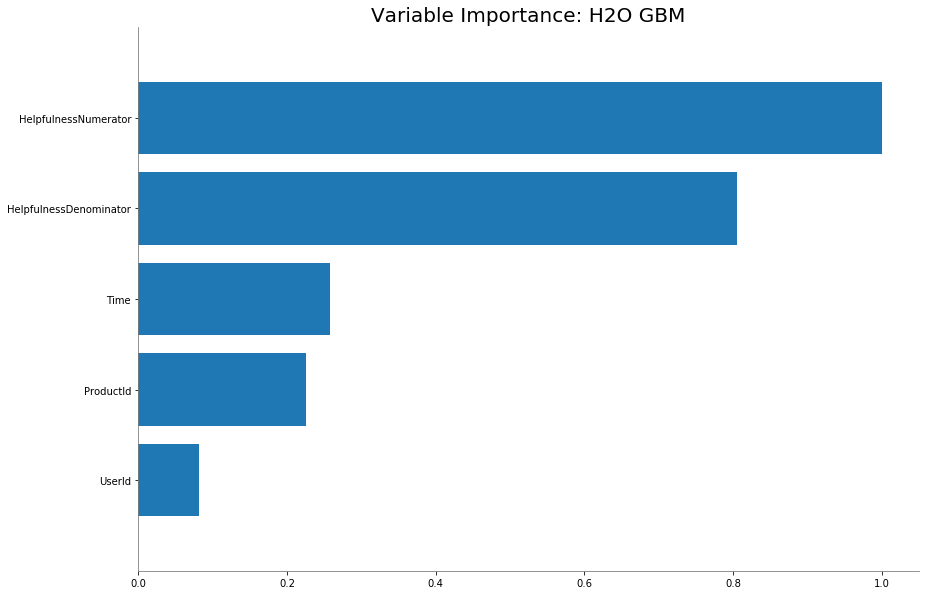

In [113]:
# Plot and Log Variable Importance
gbm_baseline.varimp_plot()
for var in gbm_baseline.varimp():
    mlflow.lm(f'varimp_{var[0]}',var[-1])

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


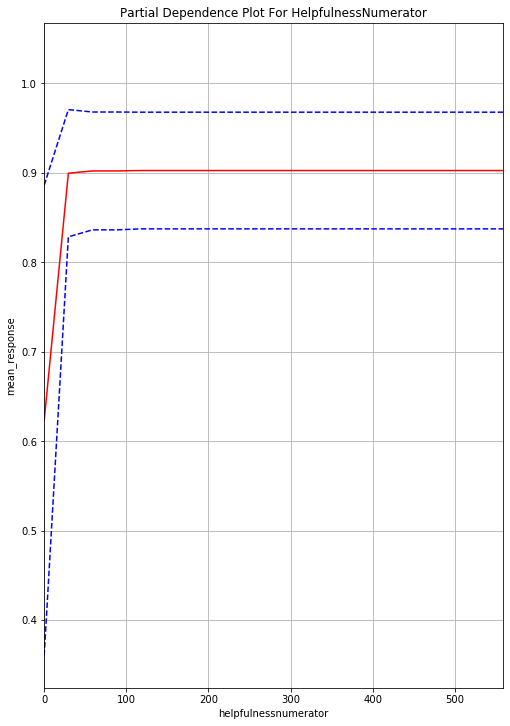

In [112]:
# Partial Dependence Plot
pdp_helpfulness = gbm_baseline.partial_plot(train, cols = ["HelpfulnessNumerator"])

In [119]:
mlflow.end_run()

# There is room for improvement 
## Let's now Tokenize words in the Review
### But first, let's start our new run

In [61]:
# Start new mlflow run
mlflow.start_run(run_name='review_tokenizer')
mlflow.lp('source data table', f'{get_user()}.AMAZON_REVIEWS')
# Get common stop words from H2O
data_path = "https://splice-demo.s3.amazonaws.com/stop_words.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])
print(STOP_WORDS)

['all', 'just', 'being', 'over', 'both', 'through', 'yourselves', 'its', 'before', 'o', 'hadn', 'herself', 'll', 'had', 'should', 'to', 'only', 'won', 'under', 'ours', 'has', 'do', 'them', 'his', 'very', 'they', 'not', 'during', 'now', 'him', 'nor', 'd', 'did', 'didn', 'this', 'she', 'each', 'further', 'where', 'few', 'because', 'doing', 'some', 'hasn', 'are', 'our', 'ourselves', 'out', 'what', 'for', 'while', 're', 'does', 'above', 'between', 'mustn', 't', 'be', 'we', 'who', 'were', 'here', 'shouldn', 'hers', 'by', 'on', 'about', 'couldn', 'of', 'against', 's', 'isn', 'or', 'own', 'into', 'yourself', 'down', 'mightn', 'wasn', 'your', 'from', 'her', 'their', 'aren', 'there', 'been', 'whom', 'too', 'wouldn', 'themselves', 'weren', 'was', 'until', 'more', 'himself', 'that', 'but', 'don', 'with', 'than', 'those', 'he', 'me', 'myself', 'ma', 'these', 'up', 'will', 'below', 'ain', 'can', 'theirs', 'my', 'and', 've', 'then', 'is', 'am', 'it', 'doesn', 'an', 'as', 'itself', 'at', 'have', 'in'

In [240]:
reviews['Text']

Text
"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"
"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)<br /><br />They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats."
We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.
"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!"
"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.<br /><br />The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.<br /><br />If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amounts or much direction. In comparison, the Annie Chun's package gives clear, specific directions on rice noodle preparation and two recipes.<br /><br />I use rice noodles = maifun = rice sticks = sometimes called vermicelli for making the Vietnamese salad ""bun tofu"", to serve with stir-fried veggies or in lettuce rolls. They can also be used in spring rolls/egg rolls. When cooking with thin rice noodles, be careful not to oversoak/overcook/overmix or they tend to disintegrate. Asian rice noodle vermicelli (maifun) are not the same as Italian vermicelli and are not readily interchangeable. If making an Italian recipe, the best results would be expected from Italian pasta and not maifun.<br /><br />A few final notes... Both Peacock and Annie Chun's brown rice noodles are gluten free. T

## Now we can train our Word2Vec model
<blockquote>We can time how long it takes to train the word vectorizer, and log the vector size so we can change it and see how performance changes. Then we can look at some word synonyms to see how well the tokenizer did</i></br><footer>Splice Machine</footer></blockquote><br>

In [126]:
from h2o.estimators.word2vec import H2OWord2vecEstimator
vec_size = 100
w2v_model = H2OWord2vecEstimator(vec_size = vec_size, model_id = "w2v.hex")
# We can change this later and see how performance changes
mlflow.lp('word_vec_size', vec_size)
with mlflow.timer('word vectorization train time'):
    w2v_model.train(training_frame=words)
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

Starting Code Block word vectorization train time... word2vec Model Build progress: |██████████████████████████████████████████| 100%
Done.
Code Block word vectorization train time:
Ran in 105.062 secs
Ran in 1.751 mins


OrderedDict([('coffe', 0.8252993226051331),
             ('expresso', 0.7982868552207947),
             ('coffees', 0.7907992005348206),
             ('espresso', 0.7904424667358398),
             ('coffeehouse', 0.7591685056686401)])

In [131]:
def tokenize( reviews ):
    review_tokens = []
    for review in reviews[0]:
        # Remove non-letters
        review = re.sub("[^a-zA-Z]"," ", review)
        review = review.lower().split()

        stops = {'all', 'just', 'being', 'over', 'both', 'through', 'yourselves', 'its', 'before', 'o', 'hadn', 'herself', 'll', 'had', 'should', 'to', 'only', 'won', 'under', 
                 'ours', 'has', 'do', 'them', 'his', 'very', 'they', 'not', 'during', 'now', 'him', 'nor', 'd', 'did', 'didn', 'this', 'she', 'each', 'further', 'where', 'few', 
                 'because', 'doing', 'some', 'hasn', 'are', 'our', 'ourselves', 'out', 'what', 'for', 'while', 're', 'does', 'above', 'between', 'mustn', 't', 'be', 'we', 'who', 
                 'were', 'here', 'shouldn', 'hers', 'by', 'on', 'about', 'couldn', 'of', 'against', 's', 'isn', 'or', 'own', 'into', 'yourself', 'down', 'mightn', 'wasn', 'your', 
                 'from', 'her', 'their', 'aren', 'there', 'been', 'whom', 'too', 'wouldn', 'themselves', 'weren', 'was', 'until', 'more', 'himself', 'that', 'but', 'don', 'with', 
                 'than', 'those', 'he', 'me', 'myself', 'ma', 'these', 'up', 'will', 'below', 'ain', 'can', 'theirs', 'my', 'and', 've', 'then', 'is', 'am', 'it', 'doesn', 'an', 
                 'as', 'itself', 'at', 'have', 'in', 'any', 'if', 'again', 'no', 'when', 'same', 'how', 'other', 'which', 'you', 'shan', 'needn', 'haven', 'after', 'most', 'such',
                 'why', 'a', 'off', 'i', 'm', 'yours', 'so', 'y', 'the', 'having', 'once'}
        review = [w for w in review if w not in stops]
        review_tokens.append(review)
    return(review_tokens)

In [137]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline as skPipe
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from gensim.sklearn_api import W2VTransformer, D2VTransformer
import pandas as pd

pdf = reviews['Text'].as_data_frame().astype('string')

data_path = "https://splice-demo.s3.amazonaws.com/stop_words.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

# vectorizer_model = skPipe(steps = [
#     ('preprocessor', FunctionTransformer(lambda x: x[0], validate=False)),
#     ('CountVector', CountVectorizer(stop_words=STOP_WORDS, token_pattern="[^a-zA-Z]", max_features=100)),
#     ('vectorizer', TfidfTransformer())
#     #('vector_returner', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True, validate=False))
# ])
vectorizer_model2 = skPipe(verbose=True,
                            steps = [
                                ('preprocessor', FunctionTransformer(tokenize, validate=False)),
                                ('word2vec', D2VTransformer())
                            ])

# tokenize and build vocab
vectorizer_model2.fit([pdf.dropna()['Text']])

Pipeline(memory=None,
         steps=[('preprocessor',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function tokenize at 0x7f81886b05f0>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('word2vec',
                 D2VTransformer(alpha=0.025, batch_words=10000, cbow_mean=1,
                                comment=None, dbow_words=0, dm=1, dm_concat=0,
                                dm_mean=None, dm_tag_count=1, docvecs=None,
                                docvecs_mapfile=None,
                                hashfxn=<built-in function hash>, hs=0, iter=5,
                                max_vocab_size=None, min_alpha=0.0001,
                                min_count=5, negative=5, sample=0.001, seed=1,
                                size=100

In [1]:
pdf.rename(columns={"Text": "sentence"})

NameError: name 'pdf' is not defined

In [ ]:
mlflow.deploy_db(vectorizer_model2, pdf, 'ben', 'sk_vec_pipe', [('MOMENT_KEY', 'INT')], run_id=mlflow.current_run_id(),
                     classes = [f'C{i+1}' for i in range(100)], verbose=True)

Saving model of size: 56999.089 KB to Splice Machine DB


In [ ]:
%%sql

insert into ben.sk_vec_pipe values('I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!', 1);

## Now we can save this model and end our run
<blockquote>We want to save this vectorizer as an <b>independent</b> <code>run</code>. This is because we may want to build more than 1 model that utilizes these word vectors. We don't want to duplicate those identical word vectors, so we can use the outputs for <b>more than one model</b>. This is the idea of a <i>feature store</i> where we use features from one dataset on multiple models. This is crucial to creating efficient ML workflow systems.

In [63]:
mlflow.log_model(vectorizer_model, 'review_vectorizer_model')
mlflow.lp('vector_size',100)
mlflow.end_run()

Saving artifact of size: 5.792 KB to Splice Machine DB


## Let's vectorize our reviews
<blockquote>Now that we have a word embedding for each word in our vocabulary, we will aggregate the words for each review using the <code>transform</code> function.  This will give us one aggregated word embedding for each review.</blockquote>

In [141]:
# Calculate a vector for each review
review_vecs = h2o.H2OFrame(vectorizer_model2.transform([pdf.fillna("")['Text']]))
# Add the review vectors to the original dataframe
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)
ext_reviews.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,-0.0341503,-0.10818,-0.0378363,-0.0664373,0.00766119,0.0289788,0.0857406,-0.00785125,-0.120758,-0.0575716,0.0857301,0.104244,-0.141921,-0.00838397,0.144448,0.00902313,0.0614638,-0.00241944,0.0303611,0.0530984,-0.0460452,-0.0806975,-0.114665,-0.0307632,0.0705416,0.12288,-0.0402827,0.0509848,-0.109168,-0.0670598,0.0467393,0.0661342,-0.00150267,0.064902,0.0437838,0.0206769,-0.0727154,-0.00707331,-0.00596179,0.0232555,-0.0423598,0.0441994,0.0154022,-0.0688855,0.000505353,0.110922,-0.0382762,0.113123,0.116474,0.0412931,0.0119825,0.0177,0.0249545,0.135765,0.0143485,0.0489837,0.00161878,-0.111903,-0.102871,0.11677,-0.09998,-0.0131311,0.0747656,-0.0290306,-0.0344619,-0.0191363,-0.0459339,0.0109364,0.0948219,0.0380888,-0.0222718,-0.0445089,-0.028453,0.000661888,-0.0749557,0.0525382,0.0656178,0.0957749,-0.0598913,-0.0801278,0.0406965,0.0178941,0.123787,-0.021983,-0.0491254,0.193216,0.0860584,0.0613115,-0.0100164,-0.169791,-0.1119,0.0402531,-0.102299,-0.0082157,-0.0750572,-0.0340265,-0.0126831,-0.0756751,0.0611046,0.0886016
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,-0.0390761,-0.0159853,0.0525692,-0.0365459,0.0239685,-0.00540454,0.00574737,0.0278542,0.035262,-0.0343393,-0.0224695,-0.00701442,0.0301193,-0.0133648,-0.0229403,0.0142804,-0.0362945,-0.0189084,-0.0122248,0.00196249,0.0115385,0.00271523,-0.0263855,-0.0432941,0.043083,0.0731997,-0.0240156,-0.0116159,0.0207294,-0.0229416,-0.0378723,0.037957,0.044218,0.0113744,0.0315505,-0.0147176,0.0231034,0.0326607,0.00390567,0.0286941,-0.0551709,-0.0132278,-0.0218749,-0.0309141,-0.000503425,-0.00909946,0.0426709,0.0254569,0.0146184,-0.0278761,0.0370015,0.0615386,0.0141969,0.00994672,0.0860573,0.00857722,-0.000906741,-0.104595,0.014108,0.018341,-0.021037,0.0251217,-0.0404073,-0.0254253,0.00293042,0.0748855,-0.00727587,0.0410046,0.00575329,-5.12304e-05,0.0849097,-0.111972,0.013228,-0.0357114,-0.0518074,0.0310287,-0.00235838,0.00408243,-0.114568,-0.0808327,0.0208117,-0.0104827,-0.100123,-0.0137341,0.00727252,0.0182758,0.0409142,0.030828,-0.00658097,-0.0826325,0.000459405,0.0296497,0.041425,-0.0252306,-0.0214588,0.0127377,-0.00114045,-0.0103909,0.00207492,-0.00463952
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,-0.0636505,-0.123733,-0.0231013,-0.0417403,0.0693997,0.0463899,0.0279045,0.0087564,-0.0762662,0.0351494,0.0971182,0.00450611,-0.0498215,-0.0250226,-0.00784616,0.0326165,-0.0154473,-0.00110973,0.0860599,0.0218876,0.0267343,-0.00762228,0.0474742,-0.0223307,0.115004,0.0864473,0.070582,0.0662224,-0.00755582,0.00218678,0.0292147,0.12444,0.0160181,0.

## Model 2: GBM with Review vectors
<blockquote>
    Now we can train a GBM like before, but include the review vectors. This should hopefully increase improvement! We'll log everything to mlflow so we can compare the results.
    </i></br><footer>Splice Machine</footer></blockquote><br>

In [142]:
from h2o.estimators import H2OGradientBoostingEstimator
mlflow.end_run()
mlflow.start_run(run_name='GBM with word vectors')
RATIOS = [0.7,0.15]
# Train Test Split
ext_train,ext_test,ext_valid = ext_reviews.split_frame(ratios=RATIOS)
# Log our ratios
mlflow.lp('ratios',RATIOS)
# Log what word vectors we're using
mlflow.lp('word vectors', 'reviews')

non_token_predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
predictors = non_token_predictors + review_vecs.names
response = 'PositiveReview'

mlflow.lp('label', response)
# There are a lot of predictors here (C1-C100 + features) so let's shorten that
mlflow.lp('predictors', non_token_predictors + [f'C1-C{len(review_vecs.columns)}'])

gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
with mlflow.timer('train_time'):
    gbm_embeddings.train(x = predictors, y = response, 
                       training_frame = ext_train, validation_frame = ext_test
                      )

# Log the model params to mlflow
mlflow.log_params(gbm_embeddings.get_params())
# Log the model to MLFlow
mlflow.log_model(gbm_embeddings, 'baseline_model')
# Log the training notebook to MLFlow
mlflow.log_artifact('MLManager H2O Demo.ipynb', 'training_notebook')
gbm_embeddings

Starting Code Block train_time... gbm Model Build progress: |███████████████████████████████████████████████| 100%
Done.
Code Block train_time:
Ran in 7.378 secs
Ran in 0.123 mins
Saving artifact of size: 1598.677 KB to Splice Machine DB
Saving artifact of size: 802.924 KB to Splice Machine DB
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_embeddings.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22988.0,5.0,5.0,5.0,31.0,32.0,31.92




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.11572445963957394
RMSE: 0.3401829796441526
LogLoss: 0.3760365771055801
Mean Per-Class Error: 0.2099203987872652
AUC: 0.871821488073347
AUCPR: 0.9559641584492758
Gini: 0.7436429761466941

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5982309112378869: 


,,0,1,Error,Rate
0,0,6921.0,8298.0,0.5452,(8298.0/15219.0)
1,1,2126.0,52683.0,0.0388,(2126.0/54809.0)
2,Total,9047.0,60981.0,0.1489,(10424.0/70028.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.598231,0.909975,249.0
1,max f2,0.413960,0.952631,319.0
2,max f0point5,0.738376,0.902438,175.0
3,max accuracy,0.629584,0.851973,235.0
4,max precision,0.971780,1.000000,0.0
5,max recall,0.118024,1.000000,392.0
6,max specificity,0.971780,1.000000,0.0
7,max absolute_mcc,0.696002,0.538403,200.0
8,max min_per_class_accuracy,0.776881,0.789802,151.0
9,max mean_per_class_accuracy,0.778415,0.790080,150.0



Gains/Lift Table: Avg response rate: 78.27 %, avg score: 78.24 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010010,0.953227,1.275851,1.275851,0.998573,0.958319,0.998573,0.958319,0.012772,0.012772,27.585073,27.585073
1,,2,0.020006,0.947908,1.272198,1.274025,0.995714,0.950350,0.997145,0.954338,0.012717,0.025489,27.219763,27.402549
2,,3,0.030002,0.943784,1.272198,1.273416,0.995714,0.945743,0.996668,0.951474,0.012717,0.038205,27.219763,27.341649
3,,4,0.040013,0.940787,1.274028,1.273569,0.997147,0.942244,0.996788,0.949165,0.012753,0.050959,27.402809,27.356950
4,,5,0.050009,0.937885,1.272198,1.273295,0.995714,0.939285,0.996573,0.947190,0.012717,0.063676,27.219763,27.329528
5,,6,0.100003,0.926013,1.265630,1.269463,0.990574,0.931762,0.993574,0.939477,0.063274,0.126950,26.563018,26.946328
6,,7,0.150011,0.916043,1.252499,1.263808,0.980297,0.920922,0.989148,0.933291,0.062636,0.189586,25.249934,26.380809
7,,8,0.200006,0.906355,1.249208,1.260159,0.977721,0.911188,0.986292,0.927766,0.062453,0.252039,24.920764,26.015850
8,,9,0.300009,0.886644,1.230785,1.250367,0.963301,0.896502,0.978628,0.917345,0.123082,0.375121,23.078460,25.036720
9,,10,0.399997,0.864590,1.198845,1.237488,0.938303,0.875843,0.968548,0.906971,0.119871,0.494992,19.884520,23.748808




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.12885289025826002
RMSE: 0.3589608478069162
LogLoss: 0.41002596498807614
Mean Per-Class Error: 0.2501866177988008
AUC: 0.8299493063417328
AUCPR: 0.9362941943634113
Gini: 0.6598986126834656

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5462768125297364: 


,,0,1,Error,Rate
0,0,1071.0,2267.0,0.6791,(2267.0/3338.0)
1,1,302.0,11233.0,0.0262,(302.0/11535.0)
2,Total,1373.0,13500.0,0.1727,(2569.0/14873.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.546277,0.897384,271.0
1,max f2,0.373048,0.948300,333.0
2,max f0point5,0.744656,0.879953,170.0
3,max accuracy,0.578970,0.827405,257.0
4,max precision,0.972891,1.000000,0.0
5,max recall,0.151857,1.000000,389.0
6,max specificity,0.972891,1.000000,0.0
7,max absolute_mcc,0.701520,0.456664,195.0
8,max min_per_class_accuracy,0.785462,0.747753,144.0
9,max mean_per_class_accuracy,0.779835,0.749813,148.0



Gains/Lift Table: Avg response rate: 77.56 %, avg score: 78.22 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010018,0.952700,1.272073,1.272073,0.986577,0.958248,0.986577,0.958248,0.012744,0.012744,27.207303,27.207303
1,,2,0.020036,0.947540,1.272073,1.272073,0.986577,0.949926,0.986577,0.954087,0.012744,0.025488,27.207303,27.207303
2,,3,0.030054,0.943292,1.246112,1.263419,0.966443,0.945395,0.979866,0.951189,0.012484,0.037971,24.611236,26.341947
3,,4,0.040005,0.939706,1.280668,1.267710,0.993243,0.941413,0.983193,0.948758,0.012744,0.050715,28.066812,26.770989
4,,5,0.050024,0.936787,1.272073,1.268584,0.986577,0.938289,0.983871,0.946661,0.012744,0.063459,27.207303,26.858369
5,,6,0.100047,0.924646,1.258185,1.263385,0.975806,0.930209,0.979839,0.938435,0.062939,0.126398,25.818547,26.338458
6,,7,0.150003,0.914117,1.252937,1.259905,0.971736,0.919355,0.977140,0.932081,0.062592,0.188990,25.293737,25.990530
7,,8,0.200027,0.904117,1.235656,1.253841,0.958333,0.909135,0.972437,0.926342,0.061812,0.250802,23.565597,25.384093
8,,9,0.300007,0.884060,1.214809,1.240833,0.942165,0.894176,0.962349,0.915623,0.121456,0.372258,21.480941,24.083334
9,,10,0.399987,0.860780,1.184461,1.226743,0.918628,0.872616,0.951420,0.904873,0.118422,0.490681,18.446085,22.674258




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-06-01 23:22:13,0.224 sec,0.0,0.412427,0.523504,0.500000,0.000000,1.000000,0.217327,0.417269,0.532610,0.500000,0.000000,1.000000,0.224434
1,,2020-06-01 23:22:15,1.671 sec,10.0,0.379921,0.455273,0.792675,0.920583,1.252912,0.179185,0.388664,0.471733,0.764690,0.904185,1.264098,0.189605
2,,2020-06-01 23:22:16,2.928 sec,20.0,0.364688,0.424574,0.826823,0.936683,1.264915,0.168818,0.375871,0.445410,0.796275,0.919941,1.263419,0.182613
3,,2020-06-01 23:22:17,4.082 sec,30.0,0.354877,0.404805,0.845680,0.945132,1.274028,0.161007,0.368700,0.430483,0.810305,0.926910,1.263419,0.178646
4,,2020-06-01 23:22:18,5.288 sec,40.0,0.347027,0.389289,0.860372,0.951428,1.275851,0.154153,0.363524,0.419554,0.820919,0.931847,1.272073,0.177839
5,,2020-06-01 23:22:19,6.559 sec,50.0,0.340183,0.376037,0.871821,0.955964,1.275851,0.148855,0.358961,0.410026,0.829949,0.936294,1.272073,0.172729



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,HelpfulnessDenominator,3240.504883,1.000000,0.171022
1,HelpfulnessNumerator,2612.727539,0.806272,0.137890
2,C59,953.958557,0.294386,0.050346
3,Time,817.789734,0.252365,0.043160
4,C51,816.664490,0.252018,0.043101
5,C98,786.702881,0.242772,0.041519
6,C74,763.126404,0.235496,0.040275
7,C4,755.322754,0.233088,0.039863
8,C35,711.211182,0.219475,0.037535
9,C21,672.725037,0.207599,0.035504



See the whole table with table.as_data_frame()


## Just like before, let's log all of our outcomes


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22988.0,5.0,5.0,5.0,31.0,32.0,31.92


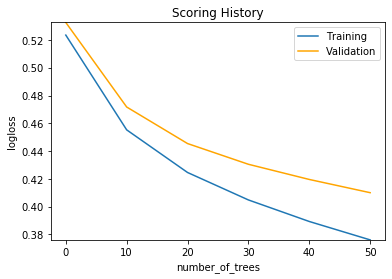

AUC on Validation Data: 0.83

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5462768125297364: 


,,0,1,Error,Rate
0,0,1071.0,2267.0,0.6791,(2267.0/3338.0)
1,1,302.0,11233.0,0.0262,(302.0/11535.0)
2,Total,1373.0,13500.0,0.1727,(2569.0/14873.0)


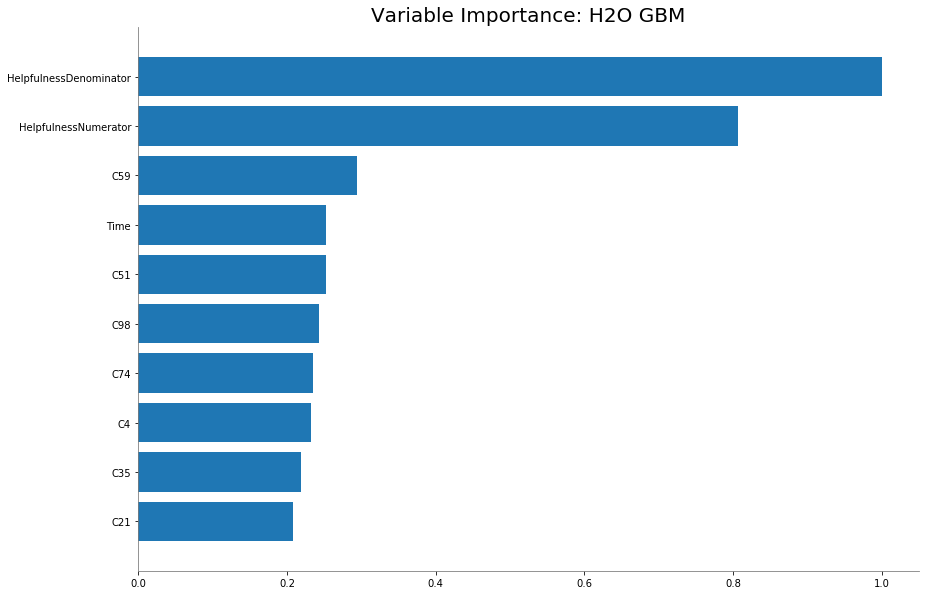

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


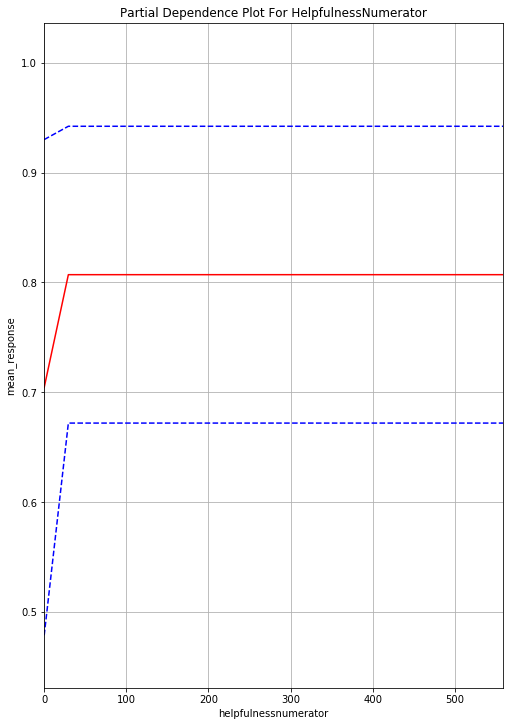

In [143]:
%matplotlib inline  
from IPython.core.display import HTML

# Print and Log Model params
params = dict(zip(gbm_embeddings.summary().col_header[1:],
                    gbm_embeddings.summary().cell_values[0][1:]))
print(gbm_embeddings.summary())
mlflow.log_params(params)


#Plot and Log Scoring history
gbm_embeddings.plot()
print("AUC on Validation Data: " + str(round(gbm_embeddings.auc(valid = True), 3)))
# Log training and validation metrics over time
for step, row in gbm_embeddings.scoring_history().iterrows():
    row_dict = row.to_dict()
    for r in row_dict:
        if 'train' in r or 'valid' in r:
            mlflow.log_metric(r, row_dict[r],step=step)


# Print and Log Confusion Matrix
print(gbm_embeddings.confusion_matrix(valid = True))
mlflow.lm('fpr', gbm_embeddings.fpr(valid=True)[0][0])
mlflow.lm('tpr', gbm_embeddings.tpr(valid=True)[0][0])
mlflow.lm('fnr', gbm_embeddings.fnr(valid=True)[0][0])
mlflow.lm('tnr', gbm_embeddings.fnr(valid=True)[0][0])
mlflow.lm('F0point5', gbm_embeddings.F0point5(valid=True)[0][1])
mlflow.lm('F1', gbm_embeddings.F1(valid=True)[0][1])
mlflow.lm('F2', gbm_embeddings.F2(valid=True)[0][1])
mlflow.lm('auc', gbm_embeddings.auc(valid = True))
mlflow.lp('threshold', gbm_embeddings.F1(valid=True)[0][0]) # First element is the threshold


# Plot and Log Variable Importance
gbm_embeddings.varimp_plot()
for var in gbm_embeddings.varimp():
    mlflow.lm(f'varimp_{var[0]}',var[-1])
    
    
# Partial Dependence Plot
pdp_helpfulness = gbm_embeddings.partial_plot(ext_train, cols = ["HelpfulnessNumerator"])

In [150]:
old_run = cur_run
cur_run = mlflow.current_run_id()
cur_exp = mlflow.current_exp_id()
link = f'/mlflow/#/metric/training_auc?runs=["{cur_run}"]&experiment={cur_exp}&plot_metric_keys=["training_logloss",\"validation_logloss\",\"training_rmse\",\"validation_rmse\"]'
HTML(f'See your metrics plot <a href={link}>here</a>')

In [152]:
gbm_embeddings.scoring_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-05-29 17:16:38,0.275 sec,0.0,0.412581,0.523793,0.500000,0.000000,1.000000,0.217553,0.413052,0.524673,0.500000,0.000000,1.000000,0.218240
1,,2020-05-29 17:16:40,1.585 sec,10.0,0.363967,0.422859,0.854668,0.948366,1.278041,0.163339,0.367460,0.429317,0.839656,0.943607,1.279165,0.171075
2,,2020-05-29 17:16:41,2.942 sec,20.0,0.340196,0.377065,0.882425,0.960111,1.274395,0.146200,0.346782,0.388486,0.864674,0.954209,1.279165,0.154420
3,,2020-05-29 17:16:42,4.218 sec,30.0,0.325502,0.348799,0.897461,0.965599,1.274395,0.134185,0.335055,0.364778,0.877488,0.958772,1.279165,0.145960
4,,2020-05-29 17:16:44,5.464 sec,40.0,0.315418,0.329413,0.907442,0.969016,1.278041,0.128006,0.327503,0.349258,0.885610,0.960976,1.279165,0.143561
5,,2020-05-29 17:16:45,6.899 sec,50.0,0.307178,0.313832,0.915321,0.971871,1.278041,0.120985,0.321558,0.337054,0.892199,0.963264,1.279165,0.142562


In [153]:
mlflow.end_run()

In [84]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))
link = f'/mlflow/#/metric/training_auc?runs=["{cur_run}","{old_run}"]&experiment={cur_exp}&plot_metric_keys=["training_auc",\"validation_auc\",\"training_pr_auc\",\"validation_pr_auc\"]'
HTML(f'See a metrics comparison <a href={link}>here</a>')

With Embeddings AUC: 0.772


NameError: name 'cur_run' is not defined

# That's some great imrpovement! So what's next?
<blockquote>We included the customer reviews and developed a better model. We've logged everything to MLFlow for detailed comparisons. Now what?<br>
    Let's deploy our models to production so we can utilize what we've built. First, we'll deploy our word vectorizer model, and then deploy our GBM model. Finally, we'll create a feed from the first model to the second, so we can see the final predictions!
        </i></br><footer>Splice Machine</footer></blockquote><br>
<img src=https://splice-demo.s3.amazonaws.com/H2O+Demo+Model+Diagram.png>

## Step 1: Deploy Word2Vec Model

In [165]:
help(mlflow.deploy_db)

Help on function _deploy_db in module splicemachine.mlflow_support.mlflow_support:

_deploy_db(fittedModel, df, db_schema_name, db_table_name, primary_key, run_id: str = None, classes=None, sklearn_args={}, verbose=False, pred_threshold=None, replace=False) -> None
    Function to deploy a trained (currently Spark, Sklearn or H2O) model to the Database.
    This creates 2 tables: One with the features of the model, and one with the prediction and metadata.
    They are linked with a column called MOMENT_ID
    
    :param fittedModel: (ML pipeline or model) The fitted pipeline to deploy
    :param df: (Spark DF) The dataframe used to train the model
                NOTE: this dataframe should NOT be transformed by the model. The columns in this df are the ones
                that will be used to create the table.
    :param db_schema_name: (str) the schema name to deploy to. If None, the currently set schema will be used.
    :param db_table_name: (str) the table name to deploy to. If

In [181]:
# Get the run_id from the name. Note that multiple runs can have the same name, so this returns a list
run_id = mlflow.get_run_ids_by_name('review_tokenizer')[0]
# Get the model from that run
w2v_model = mlflow.load_model(run_id=run_id, name='review_vectorizer_model')
deploy_df = hc.asSparkFrame(reviews[['Text']]).withColumnRenamed('Text', 'Review')
schema = 'REPLACE_ME_DBSCHEMA'
schema='BEN'
mlflow.deploy_db(w2v_model, deploy_df, schema, 'word_vec_model', [('MOMENT_KEY', 'INT')], run_id=run_id, verbose=True)

Saving model of size: 8014.339 KB to Splice Machine DB
Deploying model b8738905c16c to table BEN.word_vec_model
Creating data table ... 
 CREATE TABLE BEN.word_vec_model (
	Review VARCHAR(5000),	MOMENT_KEY INT,
	PRIMARY KEY(MOMENT_KEY)
)

Done.
Creating prediction table ... 
CREATE TABLE BEN.word_vec_model_PREDS (
        	CUR_USER VARCHAR(50) DEFAULT CURRENT_USER,
        	EVAL_TIME TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        	RUN_ID VARCHAR(50) DEFAULT 'b8738905c16c',
        	MOMENT_KEY INT,
	"C1_C0" DOUBLE,
	"C1_C1" DOUBLE,
	"C1_C2" DOUBLE,
	"C1_C3" DOUBLE,
	"C1_C4" DOUBLE,
	"C1_C5" DOUBLE,
	"C1_C6" DOUBLE,
	"C1_C7" DOUBLE,
	"C1_C8" DOUBLE,
	"C1_C9" DOUBLE,
	"C1_C10" DOUBLE,
	"C1_C11" DOUBLE,
	"C1_C12" DOUBLE,
	"C1_C13" DOUBLE,
	"C1_C14" DOUBLE,
	"C1_C15" DOUBLE,
	"C1_C16" DOUBLE,
	"C1_C17" DOUBLE,
	"C1_C18" DOUBLE,
	"C1_C19" DOUBLE,
	"C1_C20" DOUBLE,
	"C1_C21" DOUBLE,
	"C1_C22" DOUBLE,
	"C1_C23" DOUBLE,
	"C1_C24" DOUBLE,
	"C1_C25" DOUBLE,
	"C1_C26" DOUBLE,
	"C1_C27" DOUBLE,
	"C1_

## Sweet! Let's try it out

In [244]:
row = reviews['Text'][9,:]
row.set_names(['Review'])
print(row)
w2v_model.transform(words, aggregate_method="AVERAGE")

Review
"Tastes like Earl Grey, but it's green tea so it's healthier."


C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.0118207,-0.101889,0.0147137,0.278492,0.0469628,-0.172297,-0.0129039,0.0830429,-0.0914811,0.0574676,-0.0639514,0.120431,-0.0962916,-0.0178387,0.0759381,0.179793,-0.0157825,-0.12134,0.0527563,0.0573318,0.0509253,0.120528,0.15535,-0.0792156,0.0379387,-0.0660397,-0.00495673,-0.079089,-0.0337948,0.0854287,-0.270305,0.14011,0.0664857,-0.0903058,-0.0534608,0.139986,0.114537,-0.0631098,-0.145617,0.00200458,0.195605,-0.12095,0.0142132,0.00382048,0.00467813,-0.0647183,0.12261,0.10863,-0.179427,0.100265,-0.0961187,0.108058,0.0614284,-0.113856,-0.0481913,-0.0260456,0.0346338,0.127268,0.112572,-0.0689213,0.032635,0.1602,-0.0245575,-0.0889716,0.0344523,0.0388336,-0.0977627,0.0664074,-0.0214509,-0.0922424,-0.0759032,0.168529,0.0484152,0.0341554,-0.0530976,0.0814525,0.114328,0.118376,0.0836662,-0.155847,0.0524612,-0.0582578,0.0343186,-0.0191061,0.0982101,-0.0475758,0.00883958,0.159842,-0.0601515,0.0405056,-0.00583725,-0.113468,0.0123878,0.0548682,0.0231149,-0.153038,-0.0830139,0.0517786,-0.167759,0.0590884
-0.0647607,-0.0727755,-0.115707,0.0486232,0.00228006,-0.0894267,-0.0550715,0.0182499,0.104742,0.0961806,-0.0779413,-0.0978953,0.115459,-0.153234,0.0496184,0.168469,-0.0180559,0.122231,0.0145231,0.0172325,-0.0637962,-0.126619,0.15836,-0.0885775,0.0203511,-0.0701156,-0.040133,-0.304234,-0.0746839,-0.0674719,-0.103309,0.0273377,0.108569,0.0180806,-0.0350313,0.21245,0.0424701,-0.126426,-0.0514539,-0.112131,0.0785268,-0.0475902,-0.166364,0.253536,-0.0662786,0.133733,0.139492,0.144991,0.00557501,-0.079479,-0.0282375,-0.0368711,0.0286063,-0.0782206,0.00642933,0.11829,0.00523307,0.0984682,-0.0332558,0.0394351,0.0516561,0.191958,-0.0593793,-0.0620899,0.00285376,0.0289805,-0.0604133,0.0530364,-0.0330077,0.0675788,-0.0419845,0.157696,0.0653407,0.161192,0.0112189,0.111598,0.0453798,0.194989,0.138888,0.0231592,0.00690089,-0.166217,-0.0599659,-0.102449,0.0882302,-0.00776763,0.113629,0.0108894,-0.222703,-0.15212,-0.0933445,-0.0339013,0.0440877,-0.116198,0.00132958,-0.00732167,-0.157039,-0.039421,-0.0166677,-0.0640155
-0.0385096,-0.164311,0.0749115,0.105914,0.0364867,-0.14865,0.0147054,0.0432582,0.0389016,0.0396217,-0.0317641,0.095205,-0.0875548,-0.00580839,0.0605815,0.184019,-0.0828741,-0.075011,0.0940388,0.0624332,-0.0170392,-0.0428544,0.127299,0.0350129,0.0544682,-0.0712631,0.0524339,-0.114599,0.0339514,-0.0160842,-0.206147,-0.0418927,-0.0193752,0.0589492,-0.0550368,0.160735,0.0416373,-0.106153,-0.0952572,-0.0907418,0.140228,-0.141172,-0.0906205,0.172362,-0.0140963,-0.0684992,0.0649892,0.218862,-0.112363,0.0910496,-0.0594554,0.0785124,0.0352732,0.00169446,0.0356621,0.126364,-0.0982795,0.136849,0.0250553,-0.132051,0.0240202,0.0611908,-0.0153794,-0.0686614,-0.0755786,0.070956,-0.0514114,0.101125,-0.0541772,0.0603693,-0.151588,0.118073,0.0864352,0.0697684,0.0771088,0.127461,-0.00255191,0.171573,0.0162494,-0.0422113,-0.0200063,-0.016754,-0.0927813,-0.0477321,-0.0520219,-0.123997,0.147805,0.0895179,-0.0564334,0.0667794,-0.0441478,-0.263763,0.0178793,-0.0385753,0.0908309,-0.213796,-0.0448226,0.0337263,0.0551377,-0.00646082
-0.0335025,-0.104515,0.0670558,0.125524,0.121117,-0.132281,-0.0278141,0.0481801,0.0214209,0.0399683,-0.0675355,0.0613814,-0.0557912,-0.0336307,0.0842112,0.186743,-0.087822,0.00219227,0.108149,-0.00918456,-0.0524869,-0.0394393,0.0391789,0.0445749,0.0390993,-0.0879633,0.00584351,-0.144511,0.0167408,-0.13431,-0.0807045,0.0671659,0.0427141,0.041196,-0.0704532,0.181694,0.0836733,-0.0584921,-0.0831199,0.0848009,0.169781,-0.0153495,-0.190452,0.0853043,0.0573439,-0.0407362,0.107085,0.0810725,-0.200234,0.179503,-0.0225273,0.0183807,0.0216287,0.0350069,0.0458474,0

In [227]:
reviews

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)<br /><br />They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats.",1
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.,1
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!",1
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.<br /><br />The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.<br /><br />If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strip

In [243]:
words[32,:]

C1
everything


In [252]:
from h2o.assembly import *
from h2o.transforms.preprocessing import *

python_list1 = [[4,4,4,4],[4,4,4,4]]
python_list2 = [[2,1,2,2], [2,2,2,2]]

frame1 = h2o.H2OFrame(python_obj=python_list1)
frame2 = h2o.H2OFrame(python_obj=python_list2)

# assembly = H2OAssembly(steps=[]

H2OAssembly.divide(frame1, frame2)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


C1,C2,C3,C4
2,4,2,2
2,2,2,2


In [262]:
from h2o.estimators.word2vec import H2OWord2vecEstimator
help(H2OWord2vecEstimator)

Help on class H2OWord2vecEstimator in module h2o.estimators.word2vec:

class H2OWord2vecEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  H2OWord2vecEstimator(**kwargs)
 |  
 |  Word2Vec
 |  
 |  Method resolution order:
 |      H2OWord2vecEstimator
 |      h2o.estimators.estimator_base.H2OEstimator
 |      h2o.model.model_base.ModelBase
 |      h2o.model.model_base.ModelBase
 |      h2o.base.Keyed
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      Construct a new model instance.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  from_external(external=<class 'h2o.frame.H2OFrame'>)
 |      Creates new H2OWord2vecEstimator based on an external model.
 |      
 |      :param external: H2OFrame with an external model
 |      :return: H2OWord2vecEstimator instance representing the external model
 |      
 |      :examples:
 |      
 |      >>> words = h2o.create_fram

In [291]:
pdf_reviews = review_df.toPandas()

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
fit_count_vect = count_vect.fit(pdf_reviews)

x = fit_count_vect.transform(pdf_reviews.iloc[0])

NameError: name 'pdf_reviews' is not defined

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline as skPipe
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
# #Custom Transformer that extracts columns passed as argument to its constructor 
# class PreProcessor( BaseEstimator, TransformerMixin ):
#     #Class Constructor 
#     def __init__( self ):
#         pass
    
#     #Return self nothing else to do here    
#     def fit( self, X, y = None):
#         return self
    
#     #Method that describes what we need this transformer to do
#     def transform( self, X, y = None ):
#         return X[0]

# #Custom Transformer that extracts columns passed as argument to its constructor 
# class VectorSelector( BaseEstimator, TransformerMixin ):
#     #Class Constructor 
#     def __init__( self ):
#         pass
    
#     #Return self nothing else to do here    
#     def fit( self, X, y = None):
#         return self 
    
#     #Method that describes what we need this transformer to do
#     def transform( self, X, y = None ):
#         return X.toarray()


# def pre_process(X):
#     return X[0]
# def get_vector(X):
#     return X.toarray()
# p = skPipe(steps = [
#     ('preprocessor', FunctionTransformer(pre_process)),
#     ('vectorizer', TfidfVectorizer()),
#     ('vector_returner', FunctionTransformer(get_vector, accept_sparse=True))
# ])

# list of text documents
text = ["The quick brown fox jumped over the lazy dog.",
        "The dog.",
        "The fox"]

p = skPipe(steps = [
    ('preprocessor', FunctionTransformer(lambda x: x[0])),
    ('vectorizer', TfidfVectorizer()),
    ('vector_returner', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
])



# tokenize and build vocab
p.fit([text])

# vector = p.transform([[text[0]]])


splice._dropTableIfExists('ben.sk_vec_pipe')
splice._dropTableIfExists('ben.sk_vec_pipe_preds')
with mlflow.start_run(run_name = 'sk_tokenizer2'):
    mlflow.log_model(p, 'tokenizer_model2')
    mlflow.deploy_db(p, pd.DataFrame(text,columns=['sentence']), 'ben', 'sk_vec_pipe', [('MOMENT_KEY', 'INT')], run_id=mlflow.current_run_id(),
                     classes = [f'C{i}' for i in range(8)], verbose=True)


The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
The default validate=True will be replaced by validate=False in 0.22.
Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
The default validate=True will be replaced by validate=False in 0.22.
Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
The default validate=True will be replaced by validate=False in 0.22.


Saving artifact of size: 2.221 KB to Splice Machine DB
Saving model of size: 2.221 KB to Splice Machine DB
Prediction labels found. Using ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'] as labels for predictions [0, 1, 2, 3, 4, 5, 6, 7] respectively
Deploying model 893ed233c789 to table ben.sk_vec_pipe
Creating data table ... 
 CREATE TABLE ben.sk_vec_pipe (
	sentence VARCHAR(5000),	MOMENT_KEY INT,
	PRIMARY KEY(MOMENT_KEY)
)

Done.
Creating prediction table ... 
CREATE TABLE ben.sk_vec_pipe_PREDS (
        	CUR_USER VARCHAR(50) DEFAULT CURRENT_USER,
        	EVAL_TIME TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        	RUN_ID VARCHAR(50) DEFAULT '893ed233c789',
        	MOMENT_KEY INT,
	"C0" DOUBLE,
	"C1" DOUBLE,
	"C2" DOUBLE,
	"C3" DOUBLE,
	"C4" DOUBLE,
	"C5" DOUBLE,
	"C6" DOUBLE,
	"C7" DOUBLE,
	PRIMARY KEY(MOMENT_KEY)
)

Done.
Creating model prediction trigger ... 
CREATE TRIGGER runModel_ben_sk_vec_pipe_893ed233c789
 	AFTER INSERT
 	ON ben.sk_vec_pipe
 	REFERENCING NEW AS NEWROW
 	FOR EA

In [39]:
%%sql

CREATE TABLE ben.sk_vec_pipe_2 (
	sentence VARCHAR(5000),	MOMENT_KEY INT,
    CUR_USER VARCHAR(50) DEFAULT CURRENT_USER,
    EVAL_TIME TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    RUN_ID VARCHAR(50) DEFAULT '893ed233c789',
    "C0" DOUBLE,
	"C1" DOUBLE,
	"C2" DOUBLE,
	"C3" DOUBLE,
	"C4" DOUBLE,
	"C5" DOUBLE,
	"C6" DOUBLE,
	"C7" DOUBLE,
	PRIMARY KEY(MOMENT_KEY)
);
CREATE TRIGGER runModel_ben_sk_vec_pipe_2_893ed233c789
 	AFTER INSERT
 	ON ben.sk_vec_pipe_2
 	REFERENCING NEW AS NEWROW
 	FOR EACH ROW
 		INSERT INTO ben.sk_vec_pipe_2(MOMENT_KEY,"C0","C1","C2","C3","C4","C5","C6","C7") --splice-properties insertMode=UPSERT
        SELECT 	NEWROW.MOMENT_KEY, b."C0",b."C1",b."C2",b."C3",b."C4",b."C5",b."C6",b."C7" FROM new com.splicemachine.mlrunner.MLRunner('key_value', '893ed233c789', TRIM(CAST(NEWROW.sentence as CHAR(41))), 'sentence VARCHAR(5000)', 'transform', 'None') as b ("C0" DOUBLE,"C1" DOUBLE,"C2" DOUBLE,"C3" DOUBLE,"C4" DOUBLE,"C5" DOUBLE,"C6" DOUBLE,"C7" DOUBLE) 


In [428]:
import cloudpickle

In [389]:
X = 'The quick brown fox jumped over the lazy dog.'
X = [fast_float(x) for x in X.split(',')]
preds = p.transform([X])
len(preds[0])

8

In [13]:
import cloudpickle
cloudpickle.dump(p,open('model.pkl','wb'))

In [43]:
%%time
%%sql
insert into ben.sk_vec_pipe_2 (SENTENCE, MOMENT_KEY) values('The dog.', 4);

select * from ben.sk_vec_pipe_2;

CPU times: user 4.56 ms, sys: 4.02 ms, total: 8.58 ms
Wall time: 1.06 s


In [4]:
%%time
%%sql
insert into ben.sk_vec_pipe values('The dog.', 1230);

select * from ben.sk_vec_pipe_PREDS;

In [16]:
%%sql
select * from sk_vec_pipe_preds;

Query executed successfully. Affected rows : 0

In [344]:
text[0][:46]

'The quick brown fox jumped over the lazy dog.'

In [369]:
X = 'The quick brown fox jumped over the lazy dog.'
X = [x for x in X.split(',')]
p.transform([X])

array([[0.36388646, 0.27674503, 0.27674503, 0.36388646, 0.36388646,
        0.36388646, 0.36388646, 0.42983441]])